In [1]:
import os

import matplotlib.pyplot as plt
import torch
from torchvision.transforms.functional import to_pil_image

from configs.config import Config, DataConfig, ModelConfig, TrainConfig
from src.datasets.droid_dataset import DroidDatasetIndexed as DroidDataset
from src.models.fm import FM

In [2]:
checkpoint_dir = "outputs/fm_50ep"
cfg = Config()


cfg.train = TrainConfig(
    **torch.load(os.path.join(checkpoint_dir, "trainer_config.pth"), weights_only=False)
)
cfg.model = ModelConfig(
    **torch.load(os.path.join(checkpoint_dir, "model_config.pth"), weights_only=False)
)
cfg.model.guidance_scale = 0.0
cfg.data = DataConfig(
    **torch.load(os.path.join(checkpoint_dir, "data_config.pth"), weights_only=False)
)

model = FM(cfg.model).to("cuda")
model.load_state_dict(
    torch.load(os.path.join(checkpoint_dir, "checkpoints/model_50.pth"))
)
model.eval()

FM(
  (unet): UNet(
    (unet_enc): ModuleList(
      (0): Sequential(
        (0): Conv2d(15, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
        (3): Dropout(p=0.0, inplace=False)
        (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): SiLU(inplace=True)
        (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      )
      (1): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
        (3): Dropout(p=0.0, inplace=False)
        (4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (5): BatchNorm2

In [3]:
dataset = DroidDataset(
    data_path=cfg.data.data_dir,
    dataset_name=cfg.data.dataset_name,
    horizon=cfg.data.horizon,
    img_size=cfg.data.img_size,
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=5, shuffle=False)

2025-05-04 01:52:46.766213: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-04 01:52:46.780163: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746348766.798287 2843375 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746348766.804391 2843375 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746348766.819729 2843375 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

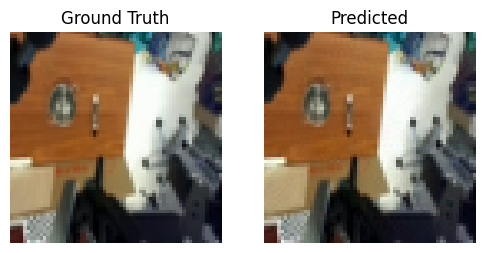

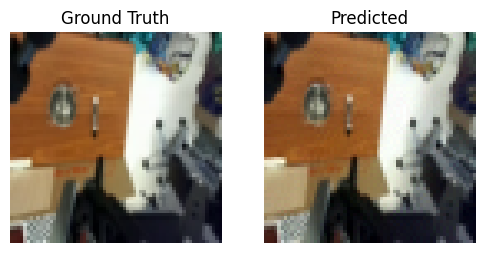

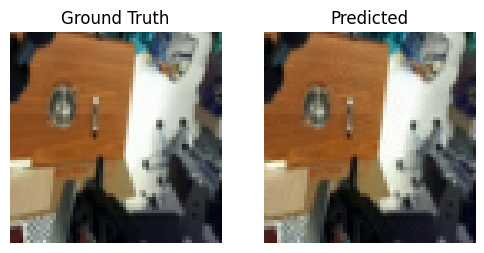

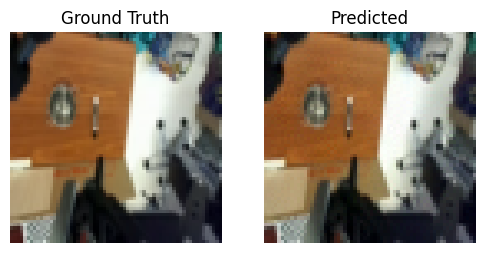

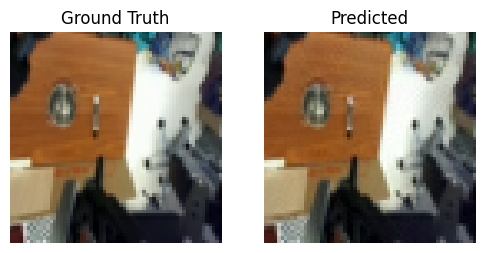

In [4]:
data = next(iter(dataloader))
context_obs = data["context_obs"].cuda()
context_acts = data["context_acts"].cuda()
B = context_obs.shape[0]

context_obs = context_obs.view(B, -1, context_obs.shape[-2], context_obs.shape[-1])
context_acts = context_acts.view(B, -1)

samples = model.sample(
    context_acts=context_acts,
    context_obs=context_obs,
    num_ts=100,
    img_wh=cfg.data.img_size,
    guidance_scale=None,
)

for i in range(B):
    pred_img = (samples[i].cpu().clamp(-1, 1) + 1) * 0.5
    gt_img = (data["obs"][i].cpu().clamp(-1, 1) + 1) * 0.5

    fig, axs = plt.subplots(1, 2, figsize=(6, 3))
    axs[0].imshow(to_pil_image(gt_img))
    axs[0].set_title("Ground Truth")
    axs[1].imshow(to_pil_image(pred_img))
    axs[1].set_title("Predicted")
    for ax in axs:
        ax.axis("off")
    plt.show()

In [10]:
idx = 0
sample = dataset[idx]
obs = sample["obs"].unsqueeze(0).cuda()
context_obs = sample["context_obs"].unsqueeze(0).view(1, -1, *cfg.data.img_size).cuda()
context_acts = sample["context_acts"].unsqueeze(0).view(1, -1).cuda()

num_frames = 100
pred_imgs = []
gt_imgs = []
for _ in range(num_frames):
    sample = dataset[idx]
    context_acts = sample["context_acts"].unsqueeze(0).view(1, -1).cuda()
    obs = sample["obs"].unsqueeze(0).cuda()
    pred_img = model.sample(
        context_acts=context_acts,
        context_obs=context_obs,
        num_ts=100,
        img_wh=cfg.data.img_size,
        guidance_scale=None,
    )

    pred_img = (pred_img.cpu().clamp(-1, 1) + 1) * 0.5
    gt_img = (obs.cpu().clamp(-1, 1) + 1) * 0.5

    pred_imgs.append(pred_img)
    gt_imgs.append(gt_img)

    context_obs = torch.cat([context_obs[:, cfg.model.input_channels:], pred_img.cuda()], dim=1)
    idx += 1
    

In [11]:
import io
import imageio
from IPython.display import display, Image
from torchvision.transforms.functional import to_pil_image

def show_gif(frames, duration=50):
    images = [to_pil_image(f.squeeze(0)) for f in frames]
    buf = io.BytesIO()
    imageio.mimsave(buf, images, format="GIF", duration=duration / 1000)
    display(Image(data=buf.getvalue()))


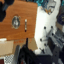

In [12]:
show_gif(gt_imgs)

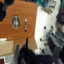

In [19]:
show_gif(pred_imgs)